<center><img src="https://is1-ssl.mzstatic.com/image/thumb/Purple122/v4/05/e7/67/05e76784-3364-b535-7e20-b3f4946a56b6/AppIcon-0-0-1x_U007emarketing-0-0-0-7-0-0-sRGB-0-0-0-GLES2_U002c0-512MB-85-220-0-0.png/434x0w.webp" style="height:150px"></center>

<hr style="border-width:2px;border-color:red">
<center><h1>Test Technique Data Scientist</h1></center>
<center><h2> Mesure de la dérive </h2></center>
<hr style="border-width:2px;border-color:red">

# Contexte

La **dérive** en apprentissage automatique (ou **"drift"** en anglais) fait référence à un **changement dans les données d'entrée ou de sortie d'un modèle** de machine learning **après son entraînement initial**. Cela peut se produire lorsque les données utilisées pour entraîner le modèle ne **reflètent plus la réalité**, ou lorsque **les conditions du problème changent de manière significative**.

La dérive des données peut affecter la précision du modèle de manière significative et peut entraîner des erreurs coûteuses dans les prévisions ou les décisions basées sur le modèle. Par conséquent, **il est important de surveiller régulièrement les performances du modèle** et de le mettre à jour en fonction des nouveaux jeux de données ou des nouvelles conditions du problème.

# Objectif

Dans ce test, vous allez implémenter des métriques permettant de mesurer la dérive d'un modèle dans un usecase de **e-commerce** où nous essayons de prédire le **panier total** (variable **`TotalCart`** : chiffre d'affaire total d'un client sur la période donnée) des clients en fonction des variables suivantes:
* **`Age`** : âge du client en années.
* **`Seniority`** : ancienneté du client en années.
* **`Orders`** : Nombre de commandes effectuées sur la période précédente.
* **`Items`** : Nombre d'items commandés sur la période précédente.
* **`AverageDiscount`** : Réduction moyenne accordée au client sur la période précédente en pourcentage.
* **`TopCategory`** : Catégorie de produits favorite du client.
* **`BrowsingTime`** : Temps total passé sur le site web sur la période précédente en secondes.
* **`EmailsOpened`** : Nombre de mails marketing ouverts par le client sur la période précédente.
* **`SupportInteractions`** : Nombre d'interactions que le client a eu avec le service client sur la période précédente.

Le jeu de données est décomposé en 4 périodes correspondant aux 4 trimestres de l'année 2022. Vous trouverez les données correspondant à chaque période dans les fichiers **`period_0.csv`**, **`period_1.csv`**, ..., **`period_3.csv`**.

Vous allez d'abord **entraîner et évaluer un modèle de machine learning** sur les données de la **période 0**. On supposera que ce modèle sera utilisé pour effectuer les prédictions de panier total sur toute l'année 2022.

Ensuite, vous devrez **implémenter des métriques de dérive** qui vous seront données et **effectuer une analyse** de celle-ci.

# Entraînement du modèle

* **Entraînez et validez** deux ou trois modèles de votre choix sur les données de la période 0. 

**Conseils**

* Vous serez évalué sur votre **rigueur** et non sur les performances du modèle.


* Il n'est pas nécessaire de faire une analyse exploratoire des données.


* Il n'est pas nécessaire de faire de recherche d'hyperparamètres optimaux non plus mais vous pouvez le faire si vous le souhaitez.

In [257]:
# Import des librairies
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
from sklearn import linear_model
from sklearn.metrics import mean_squared_error

In [258]:
df = pd.read_csv('./period_0.csv')
df.head()

,Age,Seniority,Orders,Items,AverageDiscount,TopCategory,BrowsingTime,EmailsOpened,SupportInteractions,TotalCart
0,21,2,4,7,0.14,"Clothing,Shoes & Jewelry",68.473629,3,2,34.00
1,22,0,4,5,0.50,Toys & Games,29.258063,1,0,28.28
2,22,1,2,6,0.37,"Health, Household & Baby Care",11.515517,0,0,19.33
3,19,0,2,8,0.60,Toys & Games,74.495861,1,0,26.83
4,25,1,1,5,0.58,Toys & Games,1.682705,2,1,17.67


On remarque que les données de la colonne 'TopCategory' sont des données catégorielles.

On peut utiliser la fonction `cat.codes`de pandas pour remplacer ces chaines de caractères par des valeurs numériques :

In [224]:
df['TopCategory'] = df['TopCategory'].astype('category').cat.codes   
df.head()

,Age,Seniority,Orders,Items,AverageDiscount,TopCategory,BrowsingTime,EmailsOpened,SupportInteractions,TotalCart
0,21,2,4,7,0.14,1,68.473629,3,2,34.00
1,22,0,4,5,0.50,8,29.258063,1,0,28.28
2,22,1,2,6,0.37,3,11.515517,0,0,19.33
3,19,0,2,8,0.60,8,74.495861,1,0,26.83
4,25,1,1,5,0.58,8,1.682705,2,1,17.67


On va entraîner et évaluer des modèles sur les données de la période 0. 

Pour ce faire, on entrainera les modèles sur 90% des données et on les testera sur les 10% restants.

In [225]:
nb_data_train = int(df.shape[0]*0.9)    # nombre de données qui serviront pour l'entrainement  
nb_diff = df.shape[0] - nb_data_train   # on fait la différence :c'est le nombre de données qui serviront pour le test

Ici, notre variable d'intérêt `TotalCart` est continue : on va alors chercher à implémenter des modèles de **régression**.

L'idée générale est de chercher une fonction g qui vérifie, pour chaque individu $i$ : 

$Y_i = g(X_i) + \varepsilon_i$ 

avec : 
* $Y_i$ la variable d'intérêt : `TotalCart`

* $X_i$ les variables explicatives : `Age`, `Seniority`, `Orders`, `Items`, `AverageDiscount`, `TopCategory`, `BrowsingTime`, `EmailsOpened`, et `SupportInteractions`

* $\varepsilon_i$ un bruit blanc gaussien : $\varepsilon_i \sim \mathcal{N}(0, \sigma^2)$ avec $\sigma > 0$

Le but est donc d'estimer g afin de prédire les futurs $Y_i$.

En notant $\hat{g}$ un estimateur de $g$, on a les prédictions des $Y_i$ : 

$\hat{Y_i} = \hat{g}(X_i)$

In [228]:
Y_train = df.iloc[0:nb_data_train,-1] 
Y_test  = df.iloc[-nb_diff:,-1] 

In [229]:
X_train = df.iloc[0:nb_data_train,0:-1] 
X_test  = df.iloc[-nb_diff:,0:-1] 

### Modèle de régression linéaire

On peut commencer par implémenter un modèle de **régression linéaire** : 

Pour chaque individu $i$, la variable d'intérêt s'écrit comme fonction linéaire des variables explicatives : 

$$Y_i = \theta_0 + \theta_1X_{i,1} + ... + \theta_9X_{i,9} + \varepsilon_i$$

Mathématiquement, il s'agit de résoudre le problème des moindres carrés :  

$$ \underset{\theta}{min} \; || X\theta - Y ||_2^2 $$

In [230]:
# Regression linéaire
reg_lin = linear_model.LinearRegression()
reg_lin.fit(X_train, Y_train)
y_hat_lin = reg_lin.predict(X_test)

Pour mesurer la performance de l'estimateur, on peut utliser la fonction `mean_squared_error`, qui est **l'erreur quadratique moyenne** de l'estimateur $\hat{y}$ : 

$$ MSE(y, \hat{y}) = \frac{1}{n} \sum_{i=1}^{n}{(y_i - \hat{y_i})^2} $$


In [231]:
mean_squared_error(Y_test.values,y_hat_lin)

57.6294433966216

On peut aussi analyser nos prédictions graphiquement :

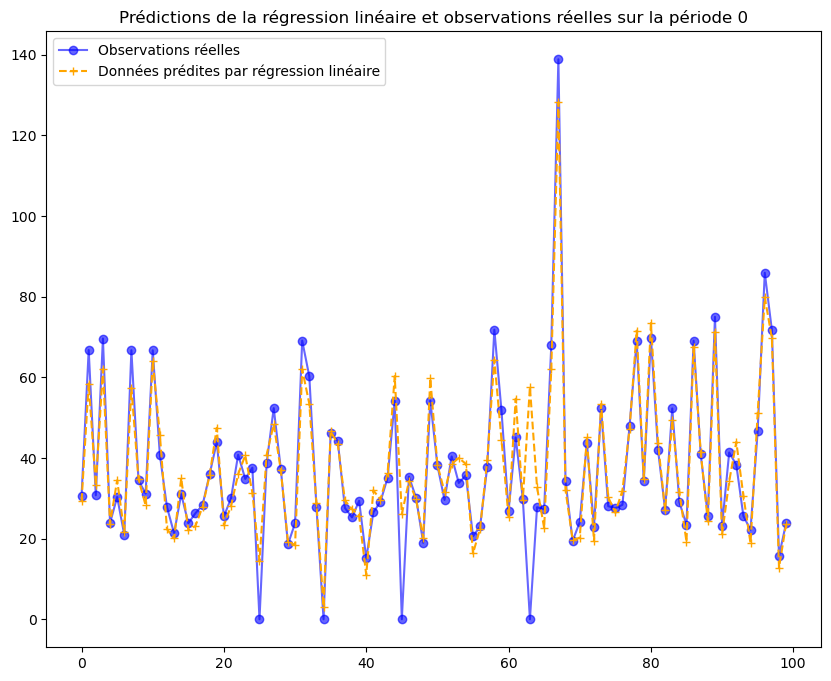

In [268]:
plt.figure(figsize=(10,8))
plt.title("Prédictions de la régression linéaire et observations réelles sur la période 0")
plt.plot(Y_test.values,marker='o',color='blue', alpha = 0.6, label = 'Observations réelles')
plt.plot(y_hat_lin,marker='+',ls='--',color='orange',label = 'Données prédites par régression linéaire')
plt.legend()

### Modèle de régression LASSO
La régression LASSO consiste à résoudre le problème pénalisé :
$$ \underset{\theta}{min} \; \frac{1}{2n} ||Y - X\theta||^2_2 + \alpha ||\theta||_1$$

avec $\alpha$ une constante. 

La fonction `LassoCV` de la librairie sklearn permet d'implémenter le meilleur modèle LASSO, pour lequel le paramètre $\alpha$ est sélectionné par validation croisée.  

In [233]:
# Régression LASSO
reg_lasso_cv = linear_model.LassoCV()
reg_lasso_cv.fit(X_train, Y_train)
y_hat_lasso_cv = reg_lasso_cv.predict(X_test)

In [234]:
mean_squared_error(y_hat_lasso_cv,Y_test.values)

56.17229666258998

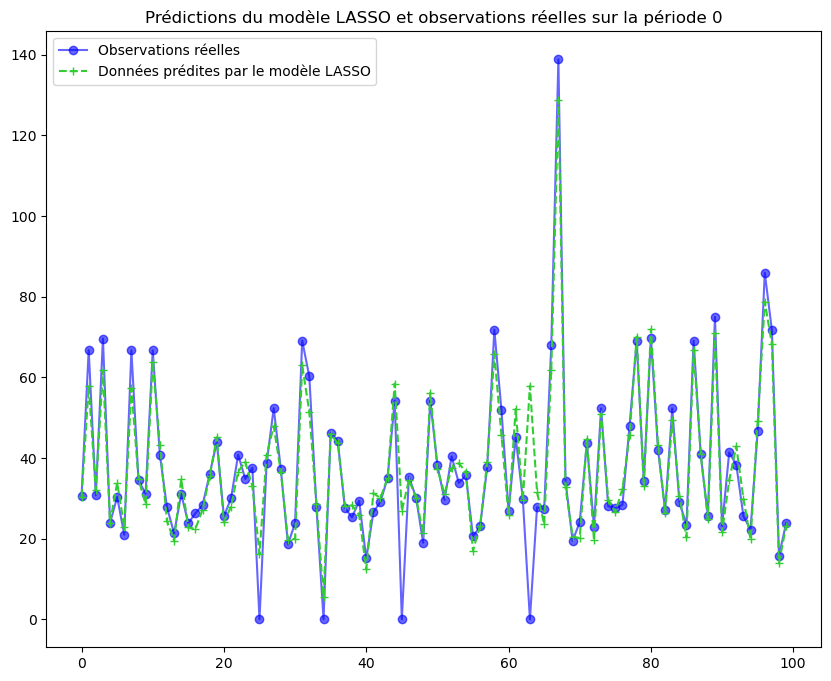

In [267]:
plt.figure(figsize=(10,8))
plt.title("Prédictions du modèle LASSO et observations réelles sur la période 0")
plt.plot(Y_test.values,marker='o',color='blue', alpha = 0.6, label = 'Observations réelles')
plt.plot(y_hat_lasso_cv,marker='+',ls='--',color='limegreen', label = 'Données prédites par le modèle LASSO')
plt.legend()

* **Entrainez votre modèle sur toute la période 0** puis **testez votre modèle** sur les données des **périodes 1, 2 et 3**. Comment évolue la performance du modèle?

Ici les modèles de régression linéaire et de régression LASSO ont des erreurs quadratiques moyennes équivalentes.

Pour la suite, on choisit de travailler avec le modèle de **régression linéaire**.

In [236]:
train = pd.read_csv('./period_0.csv')  # on entraine le modèle sur la période 0
train['TopCategory'] = train['TopCategory'].astype('category').cat.codes   

In [237]:
Y_train = train.iloc[:,-1] 
X_train = train.iloc[:,0:-1] 

In [269]:
# Pour la période 1 :
period_1 = pd.read_csv('./period_1.csv')
period_1['TopCategory'] = period_1['TopCategory'].astype('category').cat.codes

Y_test_1  = period_1.iloc[:,-1] 
X_test_1  = period_1.iloc[:,0:-1] 


reg_lin = linear_model.LinearRegression()  # régression linéaire
reg_lin.fit(X_train, Y_train)
y_hat_lin_1 = reg_lin.predict(X_test_1)

MSE_1 = mean_squared_error(y_hat_lin_1,Y_test_1.values)   # erreur quadratique moyenne

In [260]:
# Pour la période 2 :
period_2 = pd.read_csv('./period_2.csv')
period_2['TopCategory'] = period_2['TopCategory'].astype('category').cat.codes

Y_test_2  = period_2.iloc[:,-1] 
X_test_2  = period_2.iloc[:,0:-1] 


reg_lin = linear_model.LinearRegression()  # régression linéaire
reg_lin.fit(X_train, Y_train)
y_hat_lin_2 = reg_lin.predict(X_test_2)

MSE_2 = mean_squared_error(y_hat_lin_2,Y_test_2.values)   # erreur quadratique moyenne

In [270]:
# Pour la période 3 :
period_3 = pd.read_csv('./period_3.csv')
period_3['TopCategory'] = period_3['TopCategory'].astype('category').cat.codes

Y_test_3  = period_3.iloc[:,-1] 
X_test_3  = period_3.iloc[:,0:-1] 


reg_lin = linear_model.LinearRegression()  # régression linéaire
reg_lin.fit(X_train, Y_train)
y_hat_lin_3 = reg_lin.predict(X_test_3)

MSE_3 = mean_squared_error(y_hat_lin_3,Y_test_3.values)   # erreur quadratique moyenne

In [17]:
(MSE_1, MSE_2, MSE_3)

(89.45106538982495, 109.67734682549201, 235.92290566944908)

In [272]:
(MSE_3-MSE_1)/MSE_1    # évolution de l'erreur entre la période 1 et la période 3

1.63745216047796

Les erreurs quadratique moyennes du modèle vallent 89.45, 109.68 et 235.92 sur les périodes 1, 2 et 3 respectivement. 
On a une dégradation importante de la performance de notre modèle puisque que l'erreur quadratique moyenne augmente de $164 \%$ entre la période 1 et la période 3.

# Mesure de la dérive de variables catégorielles.

Pour deux distributions de probabilités discrètes $P$ et $Q$, la **divergence de Kullback–Leibler** de $P$ par rapport à $Q$ est définie par:

$$D_\text{KL}(P \parallel Q) = \sum_{x\in\mathcal{X}} P(x) \log\left(\frac{P(x)}{Q(x)}\right)$$


On définit la **divergence de Jensen-Shannon** comme une version lisse et symétrique de la divergence de Kullback-Leiber donnée par la formule suivante:

$${\rm JSD}(P \parallel Q)= \frac{1}{2}D(P \parallel M)+\frac{1}{2}D(Q \parallel M)$$

où $M=\frac{1}{2}(P+Q)$

### Exemple de calcul de $D_\text{KL}(P \parallel Q)$ : 

Soient $P$ =`[0.2, 0.3, 0.5]` et $Q$ =`[0.2, 0.4, 0.4]` deux vecteurs définissant une loi de probabilité discrete. Alors : 

$$
\begin{equation}
\begin{split}
D_\text{KL}(P \parallel Q) & = P(0) \log\left(\frac{P(0)}{Q(0)}\right)
                             + P(1) \log\left(\frac{P(1)}{Q(1)}\right)
                             + P(2) \log\left(\frac{P(2)}{Q(2)}\right)\\ \\
                           & = 0.2 \log\left(\frac{0.2}{0.2}\right)
                             + 0.3 \log\left(\frac{0.3}{0.4}\right)
                             + 0.5 \log\left(\frac{0.5}{0.4}\right) \\ \\
                           & = 0.02526...
\end{split}
\end{equation}
$$

### Exercice

* Implémenter des fonctions nommées **`KLDivergence(P, Q)`** et **`JSDivergence(P, Q)`** permettant de calculer les métriques définies ci-dessus.

**Conseils**:
* Utiliser la librairie Numpy permettant de facilement effectuer des calculs d'algèbre linéaire.

In [21]:
P = np.array([0.2, 0.3, 0.5])
Q = np.array([0.2, 0.4, 0.4])

def KLDivergence(P, Q):
    D = sum(P*np.log(P/Q))
    return D

def JSDivergence(P, Q):
    M = (P + Q)/2
    J = (KLDivergence(P, M) + KLDivergence(Q, M))/2
    return J
    

* Lancer la cellule suivante pour tester votre fonction.

In [22]:
print("K-L Divergence:", KLDivergence(P, Q))
print("J-S Divergence:", JSDivergence(P, Q))

K-L Divergence: 0.02526715392157057
J-S Divergence: 0.006367198333995731


# Mesure de la dérive de variables quantitatives.

Soit $P$ une mesure empirique d'échantillons $X_1, \ldots, X_n
$ et $Q$ une mesure empirique d'échantillons $Y_1, \ldots, Y_n$, on définit la **Distance de Wasserstein** d'ordre $p$ par la fonction suivante :

$$W_p(P, Q) = \left( \frac{1}{n}\sum_{i=1}^n \|X_{(i)} - Y_{(i)}\|^p \right)^{1/p}$$

où $X_{(1)}, \ldots, X_{(n)}$ et $Y_{(1)}, \ldots, Y_{(n)}$ sont les [**statistiques d'ordre**](https://en.wikipedia.org/wiki/Order_statistic#Notation_and_examples) des échantillons $X$ et $Y$ et $p$ un nombre entier positif.

### Exercice

* Implémenter une fonction nommée **`WassersteinDistance(X, Y, p)`** permettant de calculer cette métrique à l'ordre **`p`** à partir de **deux échantillons** **`X`** et **`Y`** que l'on supposera de même longueur.

**Conseils**:
* Vous pouvez trier les échantillons pour obtenir les statistiques d'ordre.

In [167]:
def WassersteinDistance(X, Y, p):
    A = X.copy()
    B = Y.copy()
    A.sort()    # permet d'obtenir les statistiques d'ordre
    B.sort()
    W_p = (sum(abs(A-B)**p)/A.size)**(1/p)
    return W_p

* Lancer la cellule suivante pour tester votre fonction.

In [254]:
X = np.random.beta(2, 6, 100)
Y = np.random.beta(3, 6, 100)

WassersteinDistance(X, Y, 2)

0.09174018661394584

# Étude de la dérive du modèle.

* En vous appuyant sur les métriques définies précédemment, illustrez et analysez visuellement la **dérive des données** ainsi que **la dérive du modèle** sur les périodes **1 à 3**. 


* Commenter les visualisations et déterminer si le modèle doit être mis à jour ou si sa performance est toujours acceptable. 

**Conseils**:
* Vous serez évalué sur **la rigueur et le soin** que vous donnerez à votre analyse, et sur **vos capacités à synthéthiser votre étude**. Vous ne serez pas évalué sur vos conclusions.


* Vous pouvez normaliser les données par rapport aux **moyennes et variances que vous calculerez sur la période 0** pour que les distances de Wasserstein pour différentes variables soient facilement comparables.

**Préambule :**

L'idée est de mesurer la dérive des données explicatives ainsi que la dérive de la variable d'intérêt entre la période 0 et les périodes 1, 2 et 3.

Pour ce faire, on utilisera :
* la **distance de Wasserstein**, qui permet de mesurer la dérive de variables quantitatives.
* la **divergence de Jensen-Shannon**, qui permet de mesurer la dérive de variables catégorielles.

Pour mesurer la dérive du modèle, on pourra regarder l'évolution de sa performance sur les périodes 1, 2 et 3. On pourra donc utiliser et comparer les différentes erreurs quadratiques moyennes.


In [253]:
# Import des périodes :
period_0 = pd.read_csv('./period_0.csv')
period_1 = pd.read_csv('./period_1.csv')
period_2 = pd.read_csv('./period_2.csv')
period_3 = pd.read_csv('./period_3.csv')

# On remplace les chaines de caractères par des valeurs numériques pour la variable 'TopCategory' :
period_0['TopCategory'] = period_0['TopCategory'].astype('category').cat.codes
period_1['TopCategory'] = period_1['TopCategory'].astype('category').cat.codes
period_2['TopCategory'] = period_2['TopCategory'].astype('category').cat.codes
period_3['TopCategory'] = period_3['TopCategory'].astype('category').cat.codes

### Dérive du modèle
Pour mesurer la dérive de notre modèle, on compare les erreurs quadratiques moyennes calculées sur les périodes 1, 2 et 3 :

In [242]:
MSE = (MSE_1, MSE_2, MSE_3)
MSE

(89.45106538982495, 109.67734682549201, 235.92290566944908)

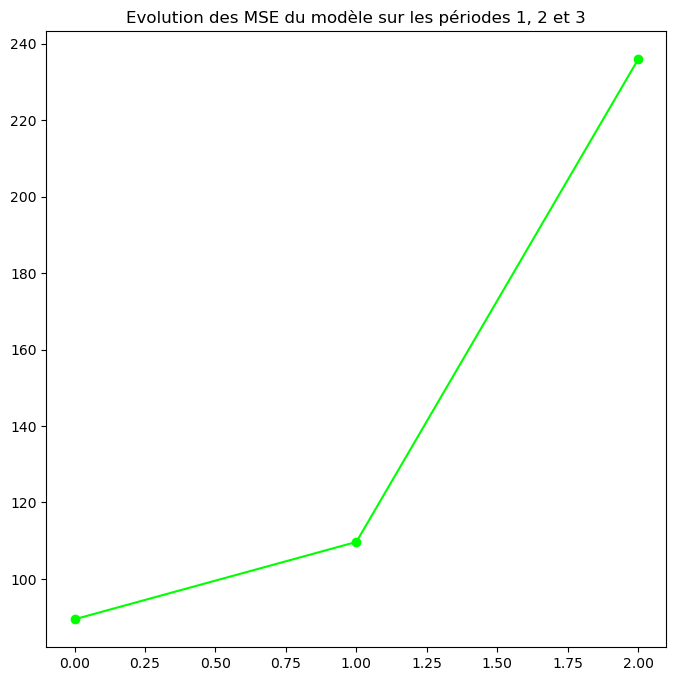

In [266]:
# Représentation graphique de la dérive du modèle :
plt.figure(figsize=(8,8))
plt.title("Evolution des MSE du modèle sur les périodes 1, 2 et 3")
plt.plot(MSE, marker = 'o', color='lime')

On remarque une forte augmentation de l'erreur quadratique moyenne, en particulier sur la période 3.

Le modèle entrainé sur la période 0 ne semble **plus adapté**, en particulier pour la période 3, et devrait être mis à jour.

### Mesure de la dérive des données `TotalCart`:

In [262]:
Y_0 = period_0.iloc[:,-1]
Y_1 = period_1.iloc[:,-1]
Y_2 = period_2.iloc[:,-1]
Y_3 = period_3.iloc[:,-1]

In [263]:
p = 2    # ordre de la distance de Wasserstein

W_Y = [WassersteinDistance(np.array(Y_0), np.array(Y_1), p), 
       WassersteinDistance(np.array(Y_0), np.array(Y_2), p),
       WassersteinDistance(np.array(Y_0), np.array(Y_3), p)]
W_Y

[6.521535486371289, 7.873598764224647, 12.608328255561876]

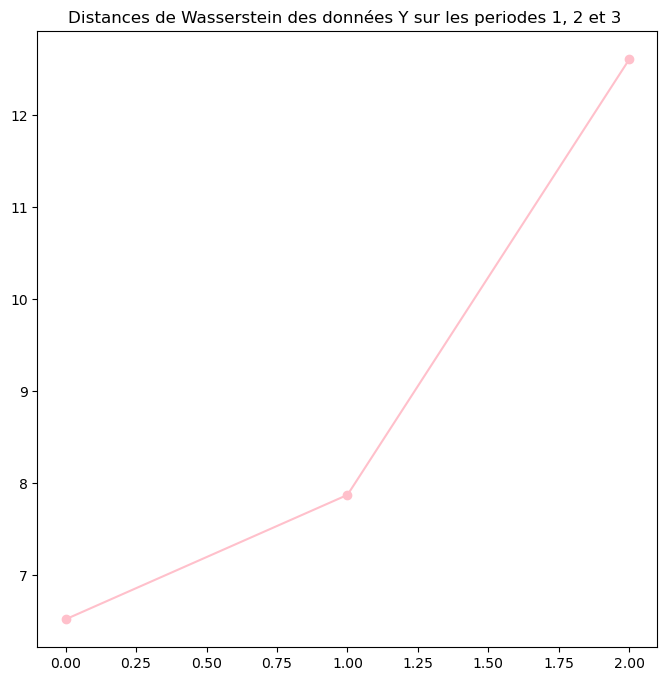

In [265]:
# Représentation graphique de la dérive des données Y:
plt.figure(figsize=(8,8))
plt.title("Distances de Wasserstein des données Y sur les periodes 1, 2 et 3 ")
plt.plot(W_Y, marker = 'o', color='pink')

On constate une augmentation significative de la distance de Wasserstein au cours des périodes, en particulier pour la période 3.
La dérive du modèle s'explique peut-être par la dérive de la variable d'intérêt `TotalCart`.

### Mesure de la dérive des données explicatives

In [173]:
X_0 = period_0.iloc[:,0:-1]
X_1 = period_1.iloc[:,0:-1]
X_2 = period_2.iloc[:,0:-1]
X_3 = period_3.iloc[:,0:-1]

Pour chaque variables explicatives, on pourra utiliser la **distance de Wasserstein** pour mesurer leurs dérives, excepté pour la variable `TopCategory` puisque c'est une variable catégorielle.

**Divergences de Jensen-Shannon pour la variable `TopCategory` :**

Pour cette variable, on mesurera sa dérive avec la **dérive de Jensen-Shannon**, qui mesure la distance entre deux lois de probabilités discrètes.

Il nous faut donc tout d'abord calculer la distribution des données de `TopCategory` de chaque période.
Pour ce faire, on peut déterminer la fréquence d'apparition de chaque élément de `TopCategory`, en utilisant la fonction `value_counts`de pandas.


In [174]:
TopCat_0 = X_0.loc[:,'TopCategory']
TopCat_1 = X_1.loc[:,'TopCategory']
TopCat_2 = X_2.loc[:,'TopCategory']
TopCat_3 = X_3.loc[:,'TopCategory']

In [273]:
Freq_TopCat_0 = TopCat_0.value_counts(normalize=True)   # fréquence de chaque catégorie
Freq_TopCat_1 = TopCat_1.value_counts(normalize=True)
Freq_TopCat_2 = TopCat_2.value_counts(normalize=True)
Freq_TopCat_3 = TopCat_3.value_counts(normalize=True)

In [176]:
Freq = pd.concat([Freq_TopCat_0, Freq_TopCat_1,Freq_TopCat_2, Freq_TopCat_3], axis=1)  # on concatène ces fréquences
Freq.columns=['period_0', 'period_1', 'period_2', 'period_3']
Freq

,period_0,period_1,period_2,period_3
0,0.259,0.227,0.226,0.217
1,0.227,0.257,0.237,0.248
8,0.171,0.179,0.205,0.180
4,0.167,0.125,0.118,0.100
3,0.099,0.106,0.112,0.131
2,0.049,0.062,0.063,0.084
7,0.016,0.032,0.026,0.031
6,0.009,0.007,0.011,0.007
5,0.003,0.005,0.002,0.002


On peut à présent passer au calcul de la **divergence de Jensen-Shannon** pour chacune des périodes :

In [177]:
JS_1 = JSDivergence(Freq.loc[:,'period_1'], Freq.loc[:,'period_0'])
JS_2 = JSDivergence(Freq.loc[:,'period_2'], Freq.loc[:,'period_0'])
JS_3 = JSDivergence(Freq.loc[:,'period_3'], Freq.loc[:,'period_0'])

In [178]:
JS = (JS_1, JS_2, JS_3)
JS

(0.004543012975517583, 0.004842393153548318, 0.010243641370144203)

On observe là aussi une croissance de la divergence de Jensen-Shannon.

**Distances de Wasserstein des autres données explicatives :**

A présent, pour chaque période $i$, on crée un vecteur $W_i$ de $\mathbb{R}^9$qui contient les **distances de Wasserstein** des données explicatives entre la période $i$ et la période $0$.

Pour la variable `TopCategory`, on mettra les **divergences de Jensen-Shannon** calculées précedemment.

In [252]:
p = 2    # ordre de la distance de Wasserstein

W_1 = []
for c in X_0.columns:
    if c == 'TopCategory':
        W_1.append(JS_1)   
    else:
        W_1.append(WassersteinDistance(np.array(X_0.loc[:,c]), np.array(X_1.loc[:,c]), p))

W_2 = []
for c in X_0.columns:
    if c == 'TopCategory':
        W_2.append(JS_2)
    else:
        W_2.append(WassersteinDistance(np.array(X_0.loc[:,c]), np.array(X_2.loc[:,c]), p))

W_3 = []
for c in X_0.columns:
    if c == 'TopCategory':
        W_3.append(JS_3)
    else: 
        W_3.append(WassersteinDistance(np.array(X_0.loc[:,c]), np.array(X_3.loc[:,c]), p))

A présent, on peut observer graphiquement l'évolution de la dérive pour chaque variable explicative :

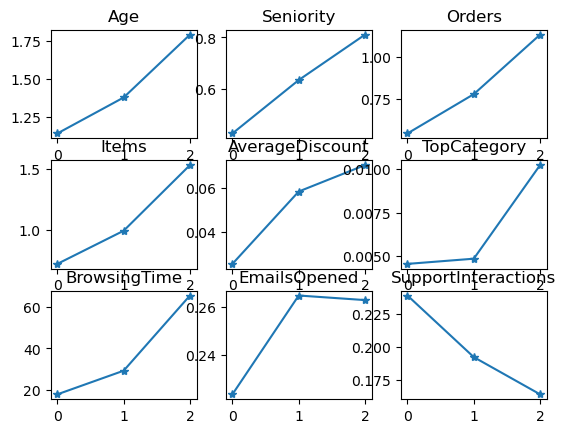

In [250]:
# Représentation graphique de la dérive des données :
fig, axs = plt.subplots(3, 3)
axs = axs.ravel()
for idx, ax in (enumerate(axs)):
    ax.plot([W_1[idx],W_2[idx], W_3[idx]], marker ='*')
    ax.set_title(period_1.columns[idx])

On observe que les mesures de la dérive des variables augmentent toutes au cours des périodes, sauf pour la variable `SupportInteractions`qui voit sa distance de Weisserstein diminuer.

Les variables `Age`, `Orders`, `Items`, `TopCategory`et `BrowsingTime` ont une dérive qui suivent la même tendance que la dérive des données `TotalCart`et que la dérive du modèle. 
La dérive de ces variables explicatives peut aussi être à l'origine de la dérive de notre modèle. 

### Normalisation des données :

En normalisant les données par rapport aux moyennes et variances calculées sur la période 0 :

**Normalisation de la variable d'intérêt `TotalCart` :**

In [205]:
mean_y = Y_0.mean()    # moyenne de la variable sur la période 0
std_y = Y_0.std()   # écart-type des variables sur la période 0

Y_0_norm = Y_0.copy()
Y_1_norm = Y_1.copy()
Y_2_norm = Y_2.copy()
Y_3_norm = Y_3.copy()

# normalisation :
Y_0_norm = (Y_0_norm - mean_y)/std_y
Y_1_norm = (Y_1_norm - mean_y)/std_y
Y_2_norm = (Y_2_norm - mean_y)/std_y
Y_3_norm = (Y_3_norm - mean_y)/std_y

In [209]:
p = 2    # ordre de la distance de Wasserstein

W_Y_norm = [WassersteinDistance(np.array(Y_0_norm), np.array(Y_1_norm), p), 
       WassersteinDistance(np.array(Y_0_norm), np.array(Y_2_norm), p),
       WassersteinDistance(np.array(Y_0_norm), np.array(Y_3_norm), p)]
W_Y_norm

[2.37894069255937, 2.378946764979351, 2.3789593434086016]

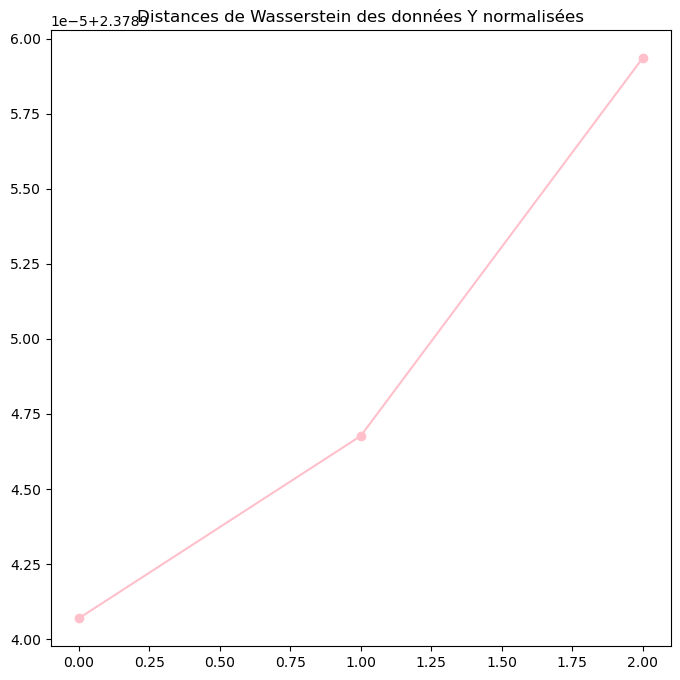

In [264]:
# Représentation graphique de la dérive des données Y:
plt.figure(figsize=(8,8))
plt.title("Distances de Wasserstein des données Y normalisées")
plt.plot(W_Y_norm, marker = 'o', color='pink')

Ici, on observe une très faible augmentation de la distance de Wasserstein, de l'ordre de $1e^{-5}$.

La dérive de la variable d'intérêt `TotalCart` n'est finalement peut-être pas à l'origine de la dérive de notre modèle.

**Normalisation des variables explicatives :**

In [246]:
means = X_0.loc[:,X_0.columns!='TopCategory'].mean(axis=0)    # moyenne des variables sur la période 0
std = X_0.loc[:,X_0.columns!='TopCategory'].std(axis=0)   # écart-type des variables sur la période 0

X_0_norm = X_0.copy()
X_1_norm = X_1.copy()
X_2_norm = X_2.copy()
X_3_norm = X_3.copy()

# normalisation :
X_0_norm.loc[:,X_0_norm.columns!='TopCategory'] = (X_0_norm.loc[:,X_0_norm.columns!='TopCategory']  - means)/std
X_1_norm.loc[:,X_1_norm.columns!='TopCategory'] = (X_1_norm.loc[:,X_1_norm.columns!='TopCategory']  - means)/std
X_2_norm.loc[:,X_2_norm.columns!='TopCategory'] = (X_2_norm.loc[:,X_2_norm.columns!='TopCategory']  - means)/std
X_3_norm.loc[:,X_3_norm.columns!='TopCategory'] = (X_3_norm.loc[:,X_3_norm.columns!='TopCategory']  - means)/std

In [248]:
p = 2  # ordre de la distance de Wasserstein

W_1_norm = []
for c in X_0.columns:
    if c == 'TopCategory':
        W_1_norm.append(JS_1)   
    else :
        W_1_norm.append(WassersteinDistance(np.array(X_0_norm.loc[:,c]), np.array(X_1_norm.loc[:,c]), p))

W_2_norm = []
for c in X_0.columns:
    if c == 'TopCategory':
        W_2_norm.append(JS_2)
    else :
         W_2_norm.append(WassersteinDistance(np.array(X_0_norm.loc[:,c]), np.array(X_2_norm.loc[:,c]), p))
    
W_3_norm = []
for c in X_0.columns:
    if c == 'TopCategory':
        W_3_norm.append(JS_3)
    else :
         W_3_norm.append(WassersteinDistance(np.array(X_0_norm.loc[:,c]), np.array(X_3_norm.loc[:,c]), p))

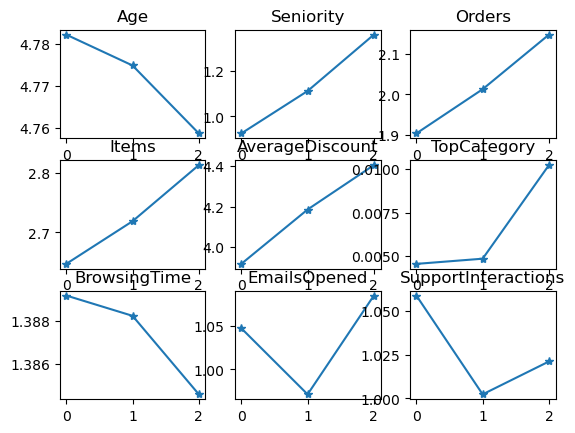

In [249]:
# Représentation graphique de la dérive des données :
fig, axs = plt.subplots(3, 3)
axs = axs.ravel()
for idx, ax in (enumerate(axs)) :
    ax.plot([W_1_norm[idx],W_2_norm[idx], W_3_norm[idx]], marker = '*')
    ax.set_title(period_1.columns[idx])            

Ici, on observe que les dérives des variables explicatives suivent des tendances différentes dans le cas normalisé.

On observe de la dérive en particulier pour les données `Seniority`, `Orders`,`Items`, `AverageDiscount`, et `TopCategory`.
La dérive de ces variables explicatives peut donc être à l'origine de la dérive de notre modèle. 